In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [150]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [151]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [152]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [153]:
# reflect an existing database into a new model
# Reflect the database schema
Base = automap_base()
Base.prepare(autoload_with=engine)

# Map the measurement and station tables
Measurement = Base.classes.measurement



In [154]:
# View all the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [155]:
# Save references to the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

# Print to verify
print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [156]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [157]:
first_row = session.query(Measurement).first()
print(first_row)

# Close the session
session.close()

# Exploratory Precipitation Analysis

In [158]:
# Create a session
session = Session(engine)

# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"Most Recent Date: {most_recent_date}")


Most Recent Date: 2017-08-23


Most Recent Date: 2017-08-23
One Year Ago: 2016-08-23 00:00:00
            date  precipitation
0     2016-08-24           0.08
1006  2016-08-24            NaN
1524  2016-08-24           2.15
702   2016-08-24           2.28
360   2016-08-24           2.15


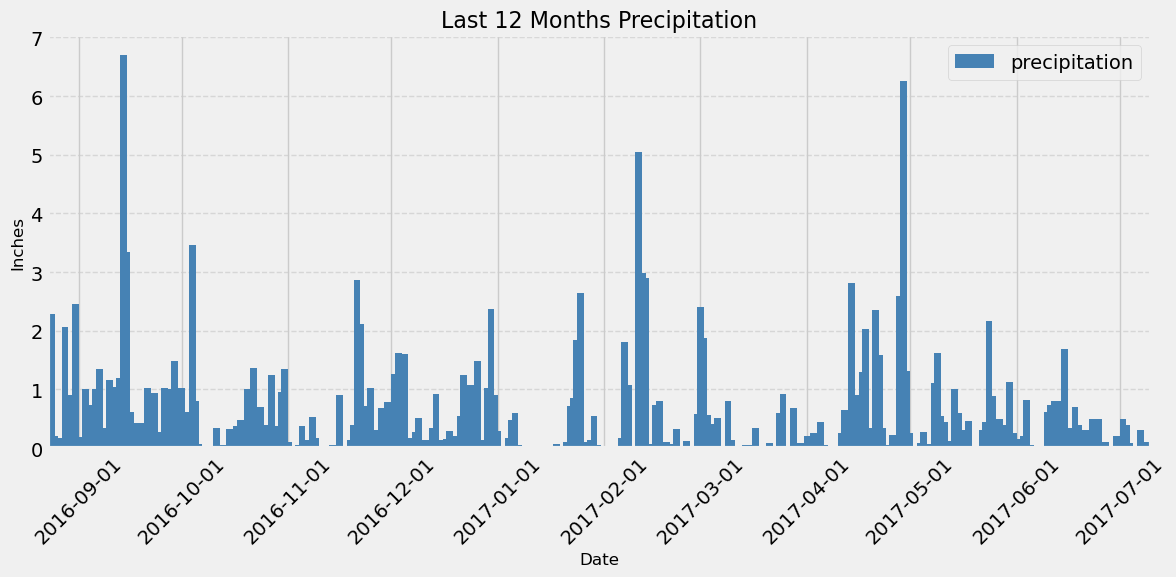

In [159]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"Most Recent Date: {most_recent_date}")

# Calculate the date one year from the last date in the data set.
from datetime import datetime, timedelta
most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - timedelta(days=365)
print(f"One Year Ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores.
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
precipitation_df = pd.DataFrame(results, columns=["date", "precipitation"])

# Sort the dataframe by date.
precipitation_df = precipitation_df.sort_values("date")
print(precipitation_df.head())

# Use Pandas Plotting with Matplotlib to plot the data.

# Ensure 'date' is in datetime format
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(precipitation_df["date"], precipitation_df["precipitation"], color="steelblue", width=2.0, label="precipitation")

# Set x-axis limits to start at August 23, 2016
plt.xlim(pd.to_datetime("2016-08-23"), pd.to_datetime("2017-07-10"))

# Set x-axis major ticks for every 2 months and format them
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format as Year-Month-Day

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title, labels, and legend
plt.title("Last 12 Months Precipitation", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.legend(loc="upper right")

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plot
plt.show()

In [160]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df["precipitation"].describe()

# Display the summary statistics
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [161]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

# Display the total number of stations
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [162]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
print("Most Active Stations and Observation Counts:")
for station, count in most_active_stations:
    print(f"Station: {station}, Observations: {count}")


Most Active Stations and Observation Counts:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [163]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
from sqlalchemy import func

# Get the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]  # The first result's station ID

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Display the results
print(f"Temperature statistics for station {most_active_station_id}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Temperature statistics for station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


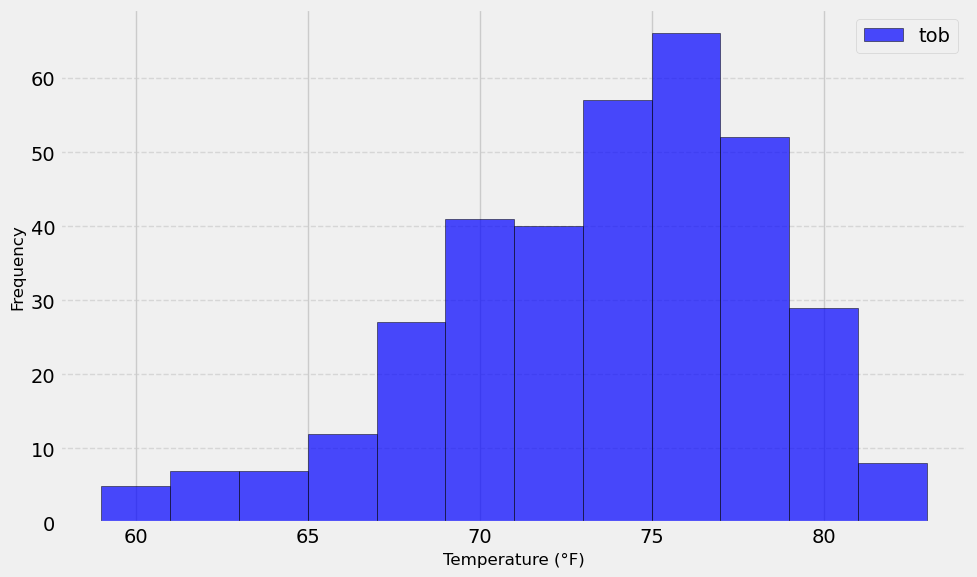

In [164]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Convert the most recent date to a Python datetime object (if not already)
most_recent_date = pd.to_datetime(most_recent_date).to_pydatetime()

# Calculate the date 12 months prior as a Python datetime object
one_year_ago = most_recent_date.replace(year=most_recent_date.year - 1)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)  # Use Python datetime here
    .all()
)

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=["tobs"])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(
    temperature_df["tobs"],
    bins=12,
    color="blue",
    alpha=0.7,
    edgecolor="black",
    label="tob"
)



plt.xlabel("Temperature (°F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")


plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


# Close Session

In [165]:
# Close Session
session.close()